# HMM with MFCC Features

This notebook expands on Nick's notebook of using traditional machine learning models with MFCC (Mel-Frequency Cepstral Coefficients) features for speech command recognition. This notebook implements HMM with MFCC, and evaluates the model created.

**Authors:** Nicholas Hefner, Arthur Ho, Hsuan-Yu Lin

## Overview
- Dataset: Google Speech Commands Dataset  
- Features: MFCC extracted using librosa
- Models: HMM
- Purpose: Compare HMM + FCC with CNN baseline

HMM + MFCC Resource:
https://datascience.netlify.app/general/2017/09/14/data_science_20.html

In [12]:
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 38.1 MB/s  0:00:00 36.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [librosa]━  9/12 [numba]te]


In [14]:
## 1. Setup and Imports

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [8]:
# Additional imports for HMM
!pip install hmmlearn
import sys
sys.path.append("/Users/arthurho/Library/Python/3.13/lib/python/site-packages")
from hmmlearn import hmm

In [15]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Dataset


In [49]:
# Dataset path (same as baseline CNN notebook)
DATASET_PATH = 'mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

print(f"Dataset location: {data_dir}")
# Audio parameters
SAMPLE_RATE = 16000
DURATION = 1.0  # seconds

# List commands
commands = [d.name for d in data_dir.iterdir() if d.is_dir()]
print(f"Commands: {commands}")


Dataset location: mini_speech_commands
Commands: ['right', 'go', 'no', 'left', 'stop', 'up', '.ipynb_checkpoints', 'down', 'yes']


## 3. Extract MFCC Features

MFCC (Mel-Frequency Cepstral Coefficients) are commonly used features for speech recognition. They capture the power spectrum of audio in a way that mimics human auditory perception.


In [30]:
def extract_mfcc_seq(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)        # (n_mfcc, T)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    feats = np.vstack([mfcc, delta, delta2])                      # (3*n_mfcc, T)
    return feats.T                                                # (T, 3*n_mfcc)

In [50]:
X_seqs = []      # list of sequences, each (T_i, D)
y_labels = []    # list of string labels, e.g. "right"

print("Extracting MFCC sequences for HMM...")
for command in tqdm(commands):
    command_dir = data_dir / command
    for audio_file in command_dir.glob("*.wav"):
        seq = extract_mfcc_seq(str(audio_file))
        if seq is not None:
            X_seqs.append(seq)
            y_labels.append(command)

print("Number of sequences:", len(X_seqs))
print("Example sequence shape:", X_seqs[0].shape)

Extracting MFCC sequences for HMM...


100%|█████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]

Number of sequences: 8000
Example sequence shape: (32, 39)


## 4. Prepare Data for Training


In [32]:
from sklearn.model_selection import train_test_split

X_train_seqs, X_test_seqs, y_train, y_test = train_test_split(
    X_seqs,
    y_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=y_labels,
)

print("Training set size:", len(X_train_seqs))
print("Test set size:", len(X_test_seqs))

Training set size: 6400
Test set size: 1600


In [33]:
scaler = StandardScaler()

all_frames = np.vstack(X_train_seqs)  
scaler.fit(all_frames)

X_train_seqs = [scaler.transform(seq) for seq in X_train_seqs]
X_test_seqs  = [scaler.transform(seq) for seq in X_test_seqs]

## 5. HMM


In [35]:
unique_labels = sorted(set(y_train))
label_to_hmm = {}

n_components = 8 
n_iter = 100

for label in unique_labels:
    seqs = [X_train_seqs[i] for i in range(len(X_train_seqs)) if y_train[i] == label]
    
    lengths = [s.shape[0] for s in seqs]        
    X_concat = np.vstack(seqs)                  

    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=n_iter,
        random_state=SEED,
        verbose=False,
    )

    model.fit(X_concat, lengths)
    label_to_hmm[label] = model
    print(f"Trained HMM for label '{label}' on {len(seqs)} sequences")

Trained HMM for label 'down' on 800 sequences
Trained HMM for label 'go' on 800 sequences
Trained HMM for label 'left' on 800 sequences
Trained HMM for label 'no' on 800 sequences
Trained HMM for label 'right' on 800 sequences
Trained HMM for label 'stop' on 800 sequences
Trained HMM for label 'up' on 800 sequences
Trained HMM for label 'yes' on 800 sequences


## 6. Predictions & Accuracy


In [37]:
def predict_hmm(seq, models):
    scores = {}
    for label, model in models.items():
        try:
            scores[label] = model.score(seq)
        except:
            scores[label] = -np.inf  
    return max(scores, key=scores.get), scores

In [38]:
y_pred = []

for seq in X_test_seqs:
    label_hat, _ = predict_hmm(seq, label_to_hmm)
    y_pred.append(label_hat)

In [39]:
accuracy = np.mean(np.array(y_pred) == np.array(y_test))
print(f"HMM Accuracy: {accuracy:.4f}")

HMM Accuracy: 0.8337


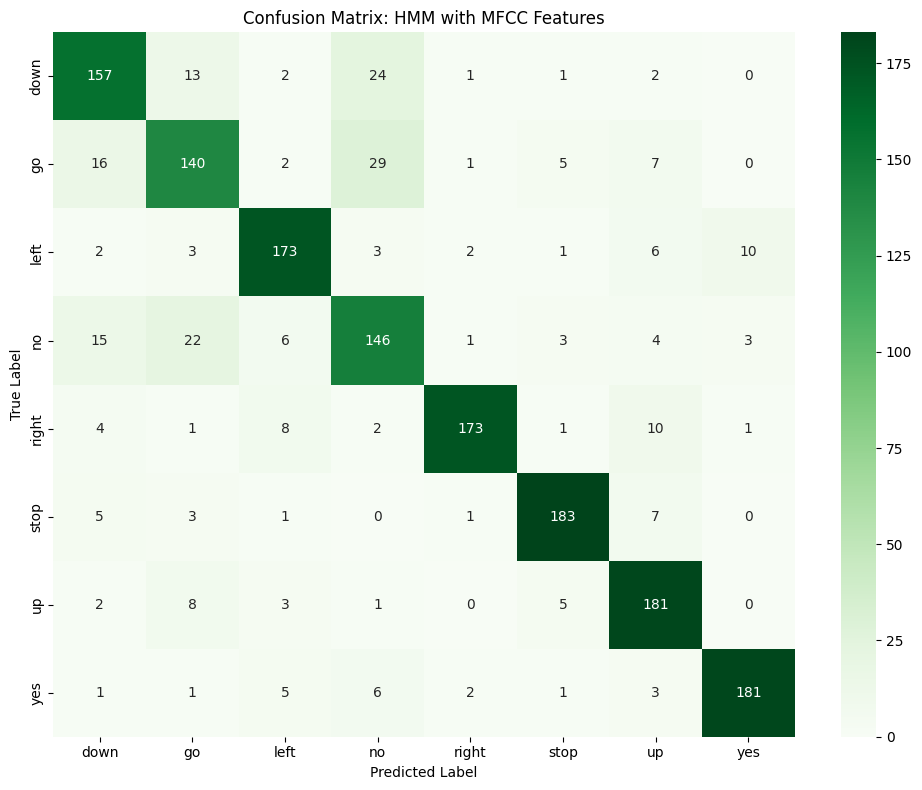

In [51]:
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=unique_labels,
    yticklabels=unique_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: HMM with MFCC Features')
plt.tight_layout()
plt.savefig('confusion_matrix_HMM_MFCC.png', dpi=150, bbox_inches='tight')
plt.show()


In [48]:
# Classification report
print(f"\nClassification Report HMM")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=unique_labels))



Classification Report HMM
              precision    recall  f1-score   support

        down       0.78      0.79      0.78       200
          go       0.73      0.70      0.72       200
        left       0.86      0.86      0.86       200
          no       0.69      0.73      0.71       200
       right       0.96      0.86      0.91       200
        stop       0.92      0.92      0.92       200
          up       0.82      0.91      0.86       200
         yes       0.93      0.91      0.92       200

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600

